In [199]:
import pandas as pd
import pickle
import joblib
import os
import tempfile
from sklearn.preprocessing import MinMaxScaler

import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [200]:
def load_data(path):
    df = pd.read_csv(path, index_col='date')
    df.index = pd.to_datetime(df.index)
    
    features = df[['vwap', 'dema', 'tema', 'williams', 'rsi', 'ratingScore', 'minus_10_price', 'minus_5_price', 'minus_4_price', 'minus_3_price', 'minus_2_price']]
    target = df[['target']]
    
    return features, target#, other

def normalize_data(train_features, test_features):
    normalizer = MinMaxScaler()
    normalizer.fit(train_features)

    filename = "tesla_normalizer.pkl"
    with open("../scalers/" + filename, "wb") as file:
        pickle.dump(normalizer, file)

    train_features_n = normalizer.transform(train_features)
    train_features_df = pd.DataFrame(train_features_n, columns=train_features.columns, index=train_features.index)

    test_features_n = normalizer.transform(test_features)
    test_features_df = pd.DataFrame(test_features_n, columns=test_features.columns, index=test_features.index)

    return train_features_df, test_features_df


def save_model(model, filename, dir_path):
    temp_file = None
    try:
        # Create a temporary file in the desired directory
        temp_file = tempfile.NamedTemporaryFile(dir=dir_path, delete=False)
        temp_file.close()  # Close the file so joblib can write to it

        # Save the model to the temporary file
        joblib.dump(model, temp_file.name)

        # Move the temporary file to the final destination
        final_path = os.path.join(dir_path, filename)
        os.replace(temp_file.name, final_path)
        print(f"Model saved successfully to {final_path}")

        # Verify the file by loading it
        loaded_model = joblib.load(final_path)
        print("Model verified successfully")

    except Exception as e:
        print(f"An error occurred: {e}")

        # Clean up the temporary file if it exists
        if temp_file and os.path.exists(temp_file.name):
            os.remove(temp_file.name)
    finally:
        # Ensure the temporary file is removed if it still exists
        if temp_file and os.path.exists(temp_file.name):
            os.remove(temp_file.name)

In [201]:
def objective(trial):
    # Load your stock price dataset
    features, target = load_data('../data/clean/tesla_training_data.csv')
    
    # Split data into training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)
    X_train, X_test = normalize_data(X_train, X_test)
    
    # Define base models
    lin_reg = LinearRegression()
    
    xgb_reg = xgb.XGBRegressor(
        n_estimators=trial.suggest_int('xgb_n_estimators', 50, 500),
        max_depth=trial.suggest_int('xgb_max_depth', 3, 9),
        learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.3),
        subsample=trial.suggest_float('subsample', 0.2, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.2, 1.0),
        random_state=42
    )

    svr = SVR(
        C=trial.suggest_float('svr_C', 0.1, 10.0),
        epsilon=trial.suggest_float('svr_epsilon', 0.01, 1.0),
        kernel=trial.suggest_categorical('svr_kernel', ['linear', 'poly', 'rbf'])
    )
    
    # Define meta-model
    meta_model = LinearRegression()

    # Create the stacking regressor
    stacking_reg = StackingRegressor(
        estimators=[
            ('lin_reg', lin_reg),
            ('xgb', xgb_reg),
            ('svr', svr)
        ],
        final_estimator=meta_model
    )

    # Train the stacking regressor
    stacking_reg.fit(X_train, y_train.values.ravel())

    # Make predictions
    y_pred = stacking_reg.predict(X_test)

    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred)
    
    return rmse

# Suppress Optuna's logging output
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create and optimize the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)
trial = study.best_trial
print(f'Best trial: {trial.number}')
print(f'  Value: {trial.value}')
print(f'  Params: {trial.params}')


Best trial: 32
  Value: 100.30247083222308
  Params: {'xgb_n_estimators': 391, 'xgb_max_depth': 7, 'learning_rate': 0.23464174176915853, 'subsample': 0.2934300603590787, 'colsample_bytree': 0.37736431337912957, 'svr_C': 0.12858945095702057, 'svr_epsilon': 0.28781375431928924, 'svr_kernel': 'linear'}


In [202]:
best_params = trial.params
best_params

{'xgb_n_estimators': 391,
 'xgb_max_depth': 7,
 'learning_rate': 0.23464174176915853,
 'subsample': 0.2934300603590787,
 'colsample_bytree': 0.37736431337912957,
 'svr_C': 0.12858945095702057,
 'svr_epsilon': 0.28781375431928924,
 'svr_kernel': 'linear'}

In [203]:
best_params = trial.params
path = '../data/clean/tesla_training_data.csv'

def prep_data(path):
    features, target = load_data(path)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)
    X_train, X_test = normalize_data(X_train, X_test)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prep_data(path)

lin_reg = LinearRegression()

xgb_reg = xgb.XGBRegressor(
    n_estimators=best_params['xgb_n_estimators'],
    max_depth=best_params['xgb_max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)

svr = SVR(
    C=best_params['svr_C'],
    epsilon=best_params['svr_epsilon'],
    kernel=best_params['svr_kernel']
)

# Define meta-model
meta_model = LinearRegression()

# Create the stacking regressor
stacking_reg = StackingRegressor(
    estimators=[
        ('lin_reg', lin_reg),
        ('xgb', xgb_reg),
        ('svr', svr)
    ],
    final_estimator=meta_model
)

# Train the stacking regressor
stacking_reg.fit(X_train, y_train.values.ravel())

# Save the model
model_filename = 'tesla_stacking_regressor_model.pkl'
dir_path = "../models"
save_model(stacking_reg, model_filename, dir_path)

# Make predictions
y_pred = stacking_reg.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)


print(f"MSE: {mean_squared_error(y_pred, y_test): .2f}")
print(f"MAE: {mean_absolute_error(y_pred, y_test): .2f}")
print(f"RMSE: {root_mean_squared_error(y_pred, y_test): .2f}")
print(f"R2 score:  {stacking_reg.score(X_test, y_test): .2f}")

Model saved successfully to ../models/tesla_stacking_regressor_model.pkl
Model verified successfully
MSE:  100.30
MAE:  7.33
RMSE:  10.02
R2 score:   0.93


In [215]:
values = stacking_reg.named_estimators_['xgb'].feature_importances_
features = ['vwap', 'dema', 'tema', 'williams', 'rsi', 'ratingScore', 'minus_10_price', 'minus_5_price', 'minus_4_price', 'minus_3_price', 'minus_2_price']

In [214]:
pd.DataFrame(values, features).sort_values(0, ascending=False)

,0
vwap,0.359791
minus_2_price,0.269720
tema,0.177770
minus_5_price,0.072225
minus_3_price,0.054515
dema,0.030851
minus_4_price,0.015204
minus_10_price,0.007326
williams,0.006557
rsi,0.005544


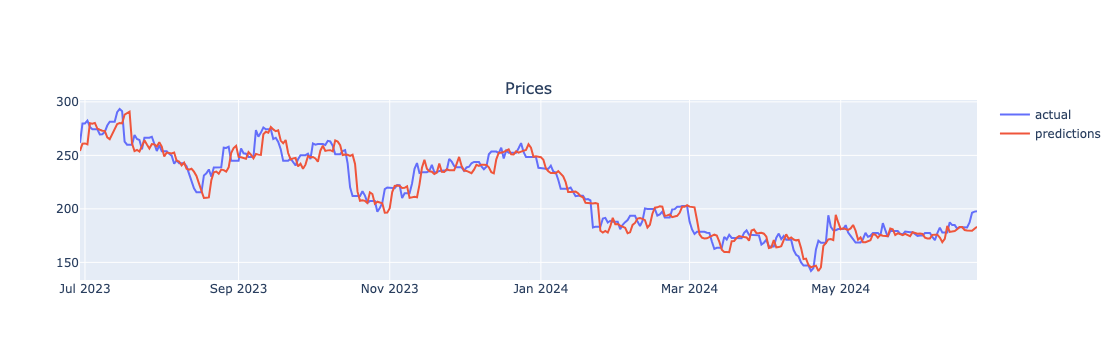

In [216]:
actual = y_test
predictions = pd.DataFrame(y_pred, columns=y_test.columns, index=y_test.index)

fig = go.Figure()

# Create the subplots
fig = make_subplots(rows=1, cols=1, shared_xaxes=False, vertical_spacing=0.1,
                    subplot_titles=("Prices", ""))

fig.add_trace(
    go.Scatter(
        x=actual.index,
        y=actual.target,
        name='actual'
    ),
    row=1,
    col=1,
    secondary_y=False)

fig.add_trace(
    go.Scatter(
        x=predictions.index,
        y=predictions.target,
        name='predictions'
    ),
    row=1,
    col=1,
    secondary_y=False)


fig.show()

In [205]:


def predict(ticker, features):
    models = {
        'GOOG': 'alphabet_stacking_regressor_model.pkl',
        'AMZN': 'amazon_stacking_regressor_model.pkl',
        'AAPL': 'apple_stacking_regressor_model.pkl',
        'META': 'meta_stacking_regressor_model.pkl',
        'MSFT': 'microsoft_stacking_regressor_model.pkl',
        'NVDA': 'nvidia_stacking_regressor_model.pkl',
        'TSLA': 'tesla_stacking_regressor_model.pkl'
    }

    scalers = {
        'GOOG': 'alphabet_normalizer.pkl',
        'AMZN': 'amazon_normalizer.pkl',
        'AAPL': 'apple_normalizer.pkl',
        'META': 'meta_normalizer.pkl',
        'MSFT': 'microsoft_normalizer.pkl',
        'NVDA': 'nvidia_normalizer.pkl',
        'TSLA': 'tesla_normalizer.pkl'
    }

    scaler = joblib.load('../scalers/' + scalers['GOOG'])
    model = joblib.load('../models/' + models['GOOG'])

    # Normalize features
    features_norm = loaded_scaler.transform(features)
    features_norm_df = pd.DataFrame(features_norm, columns=features.columns, index=features.index)

    # Make predictions
    pred = loaded_model.predict(features_norm_df)

    return pred

predict('GOOG', features)
    

array([ 57.62382671,  57.63194186,  57.61757771, ..., 180.81957239,
       182.19602774, 184.69761807])

In [246]:
path = '../data/clean/alphabet_training_data.csv'
df = pd.read_csv(path)
df.head()

,date,open,high,low,close,volume,vwap,symbol,sma,ema,...,williams,rsi,adx,ratingScore,minus_10_price,minus_5_price,minus_4_price,minus_3_price,minus_2_price,target
0,2019-07-11,57.16,57.65,56.98,57.21,23911380.0,57.2500,GOOG,55.531429,55.798228,...,-10.891089,97.607720,96.246896,4.0,54.90,56.58,56.58,55.82,56.24,57.25
1,2019-07-12,57.20,57.37,56.94,57.25,17279460.0,57.1900,GOOG,55.614286,55.991797,...,-9.900990,97.629372,94.570401,4.0,55.56,56.58,55.82,56.24,57.02,57.52
2,2019-07-13,57.20,57.37,56.94,57.25,17279460.0,57.1900,GOOG,55.614286,55.991797,...,-9.900990,97.629372,94.570401,4.0,56.08,55.82,56.24,57.02,57.21,57.68
3,2019-07-14,57.20,57.37,56.94,57.25,17279460.0,57.1900,GOOG,55.614286,55.991797,...,-9.900990,97.629372,94.570401,4.0,56.08,56.24,57.02,57.21,57.25,57.32
4,2019-07-15,57.34,57.54,56.97,57.52,18075600.0,57.3425,GOOG,55.738571,56.195558,...,-3.217822,97.775718,93.030413,4.0,56.58,57.02,57.21,57.25,57.25,57.32


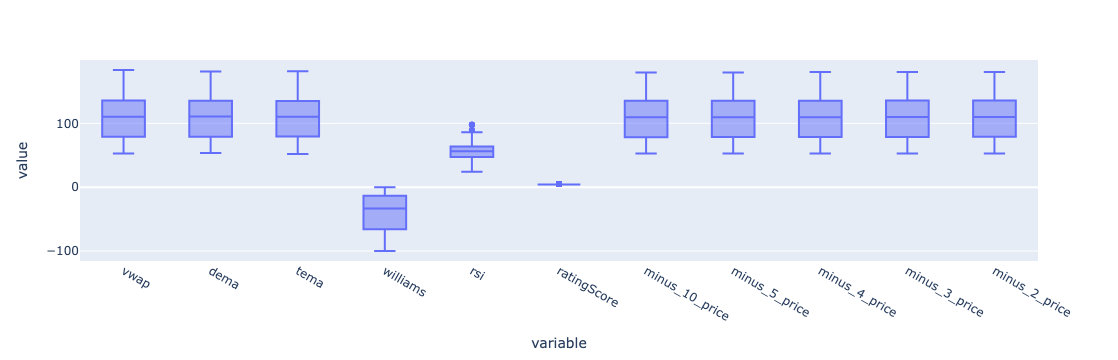

In [247]:
df_numerical = df[features.columns]
fig = px.box(df_numerical, y=df_numerical.columns)
fig.show()

In [248]:
normalizer = MinMaxScaler()
normalizer.fit(df_numerical)
df_norm = normalizer.transform(df_numerical)
df_norm = pd.DataFrame(df_norm, index=df_numerical.index, columns=df_numerical.columns)
df_norm.head()

,vwap,dema,tema,williams,rsi,ratingScore,minus_10_price,minus_5_price,minus_4_price,minus_3_price,minus_2_price
0,0.036012,0.024429,0.038478,0.890998,0.996580,0.0,0.016334,0.029590,0.029428,0.023464,0.026760
1,0.035553,0.026545,0.040562,0.900907,0.996873,0.0,0.021542,0.029590,0.023464,0.026760,0.032881
2,0.035553,0.026545,0.040562,0.900907,0.996873,0.0,0.025645,0.023593,0.026760,0.032881,0.034372
3,0.035553,0.026545,0.040562,0.900907,0.996873,0.0,0.025645,0.026908,0.032881,0.034372,0.034686
4,0.036719,0.028729,0.042704,0.967795,0.998857,0.0,0.029590,0.033062,0.034372,0.034686,0.034686


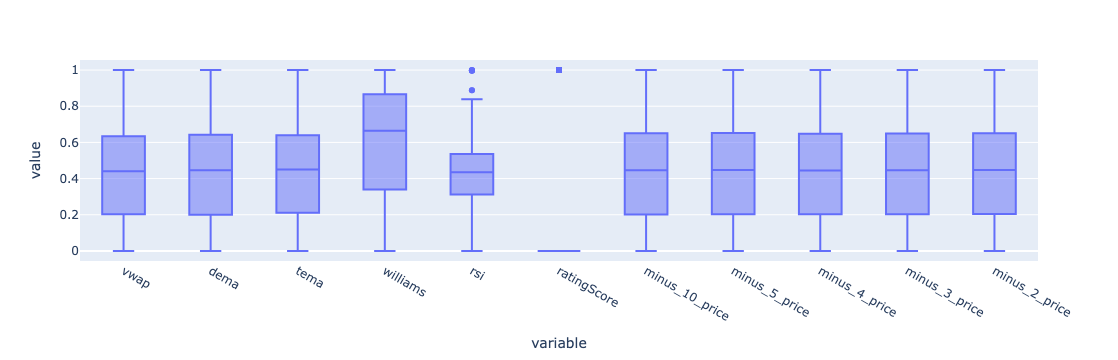

In [249]:
fig = px.box(df_norm, y=df_norm.columns)
fig.show()